# Import

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

import algorithms.bernstein_vazirani as bv
import algorithms.qft as qft

from qiskit import QuantumCircuit, transpile
from qiskit_ibm_provider import IBMProvider

from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit, IBMQBackend

# Parameters

In [2]:
def qiskit_opt_0(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=0)

def qiskit_opt_3(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=3)

def qiskit_opt_3_sabre(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=3, layout_method='sabre', routing_method='sabre')

In [3]:
min_qubits, max_qubits = 4, 14
algorithms = { 'Bernstein_Vazirani': bv, 'QFT': qft }
techniques = { 
    'Qiskit Opt 0': qiskit_opt_0, 
    'Qiskit Opt 3': qiskit_opt_3, 
    'Qiskit Opt 3 Sabre': qiskit_opt_3_sabre 
}

In [4]:
shots_per_technique = 100

In [5]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_guadalupe")

# Run Transpilation Benchmarks

## Create folders to save plots

In [6]:
import os
path = 'transpilation_benchmarks/{}'.format(backend.name)
if not os.path.exists(path):
   os.makedirs(path)

## Benchmark Transpilation with Tket

In [7]:
def pytket_run(qc, tk_backend):
    """Get compling results for a given circuit and Tket backend.
    
    Parameters:
        qc (QuantumCircuit): The circuit.
        tk_backend (TketBackend): A Tket backend instance.
        
    Returns:
        int: Number of CNOT gates in compiled circuit.
        float: Compilation time.
    """
    tk_qc = qiskit_to_tk(qc)
    st = time.perf_counter()
    tk_backend.default_compilation_pass(2).apply(tk_qc)
    ft = time.perf_counter()
    tqc = tk_to_qiskit(tk_qc)
    return (tk_to_qiskit(tk_qc).count_ops()['cx'], ft-st, tqc)

In [8]:
def qiskit_run(qc, backend, transpile_func):
    cx_counts = []
    compile_times = []
    min_cx_count = float('inf')
    best_tqc = None
    for i in range(shots_per_technique):
        st = time.perf_counter()
        tqc = transpile_func(qc, backend)
        ft = time.perf_counter()
        compile_time = ft-st
        compile_times.append(compile_time)
        cx_count = tqc.count_ops()['cx']
        cx_counts.append(cx_count)
        if min_cx_count > cx_count:
            min_cx_count = cx_count
            best_tqc = tqc
    avg_compile_time = np.average(compile_times)
    return (cx_counts, avg_compile_time, best_tqc)

In [9]:
def qiskit_run_each_technique(qc, backend):
    cx_counts_per_transpile = []
    avg_transpile_times = []
    best_tqcs = []
    for t_name, transpile_func in techniques.items():
        cx_counts, avg_time, best_tqc = qiskit_run(qc, backend, transpile_func)
        cx_counts_per_transpile.append(cx_counts)
        avg_transpile_times.append(avg_time)
        best_tqcs.append(best_tqc)
    return (cx_counts_per_transpile, avg_transpile_times, best_tqcs)

In [10]:
def compiler_benchmark(qc, backend, title=''):
    tqcs = []
    tk_backend = IBMQBackend(backend.name, group='uw-madison')
    tk_cx_count, tk_time, tk_tqc = pytket_run(qc, tk_backend)
    tqcs.append(tk_tqc)
    fig, ax = plt.subplots(figsize=(9,5))
    ax.set_title(title)
    cx_counts_per_transpile, avg_transpile_times, best_tqcs = qiskit_run_each_technique(qc, backend)
    technique_names = list(techniques.keys())    
    for i in range(len(techniques)):
        ax.hist(cx_counts_per_transpile[i], label='{} [{}]'.format(technique_names[i], np.round(avg_transpile_times[i], 3)), alpha=0.7)
    ax.axvline(tk_cx_count, color='k', linewidth=4, linestyle='--',
               label='Tket [{}]'.format(np.round(tk_time, 3)))
    ax.set_xlabel('CX count', fontsize=14)
    ax.set_ylabel('Occurance', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    fig.savefig('{}/{}.png'.format(path, title), bbox_extra_artists=(ax.get_legend(),), bbox_inches='tight')
    tqcs.extend(best_tqcs)       
    return (fig, tqcs)

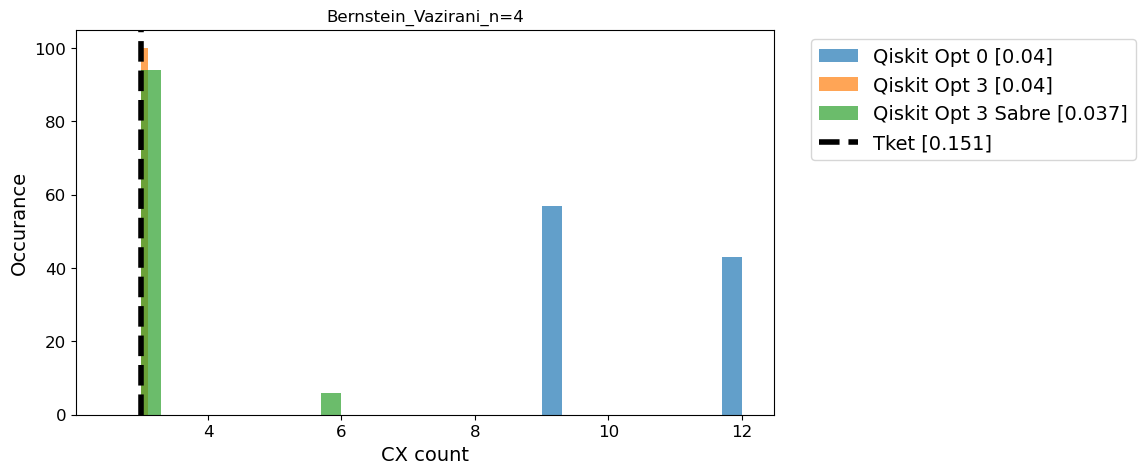

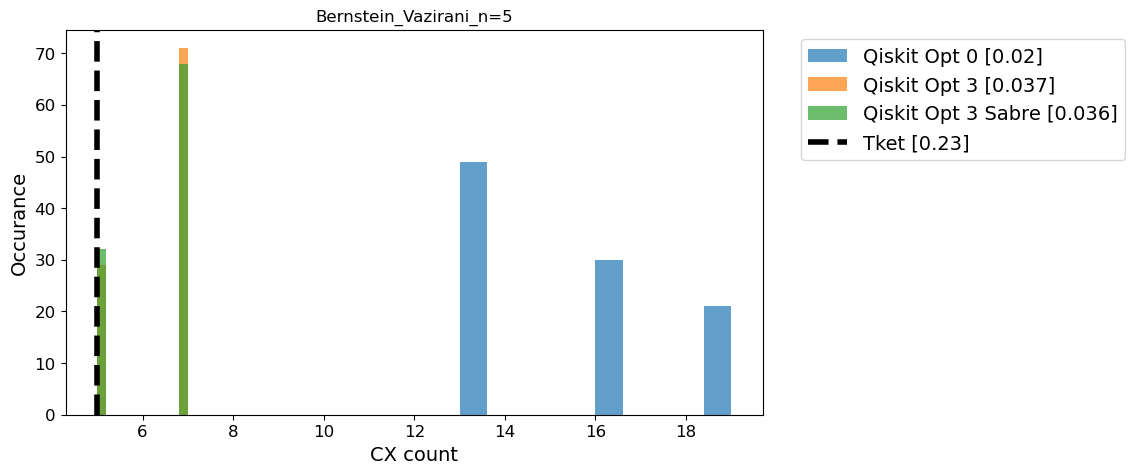

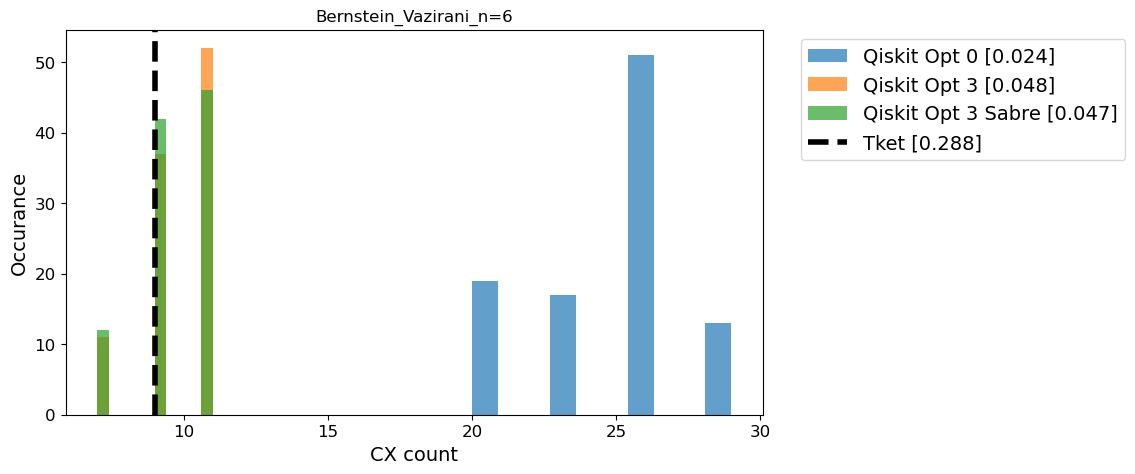

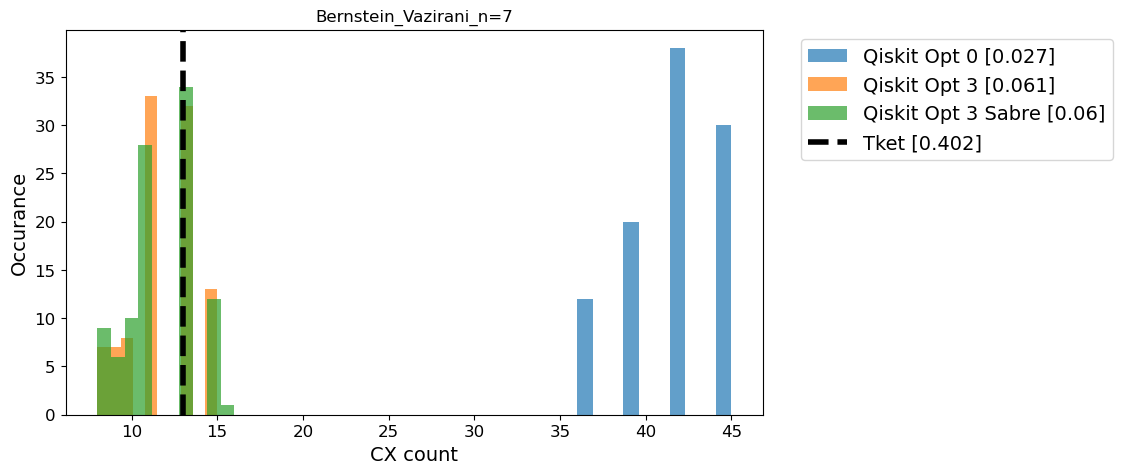

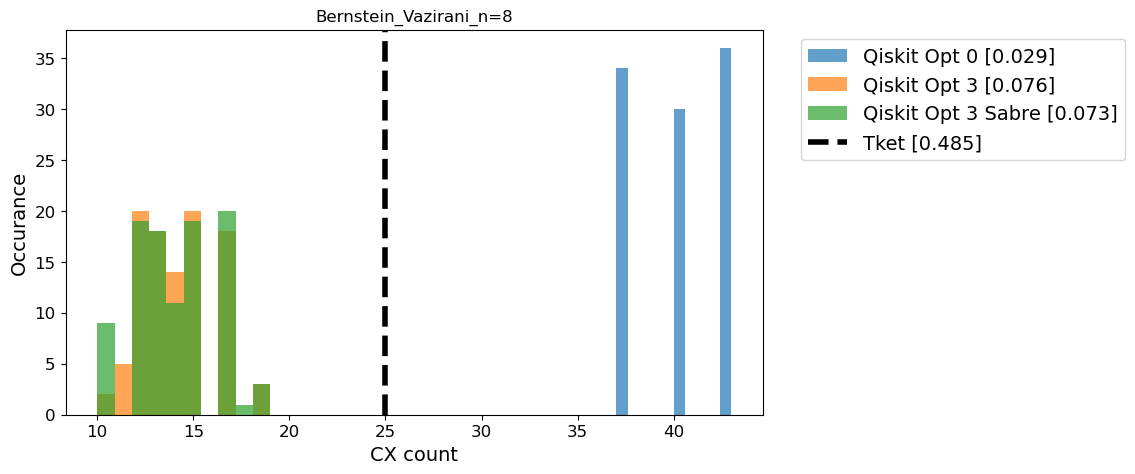

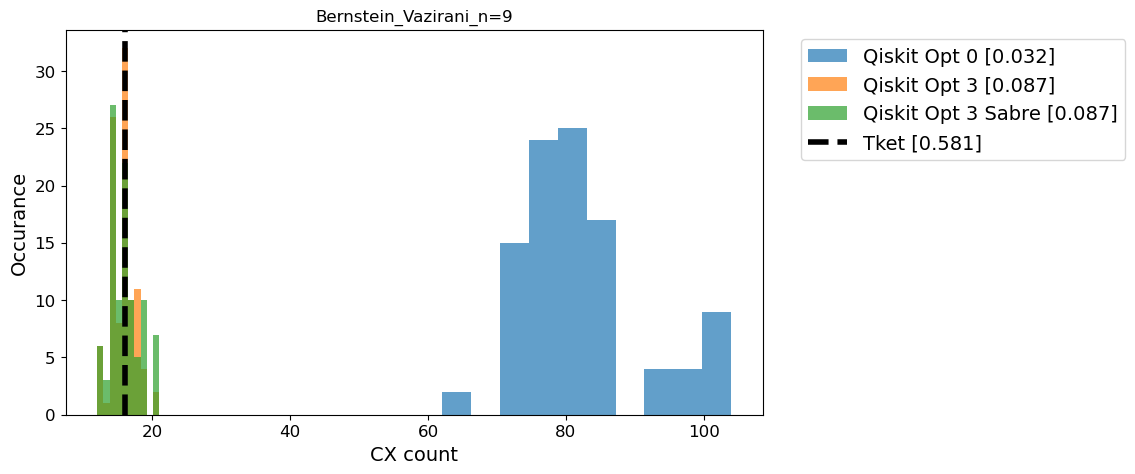

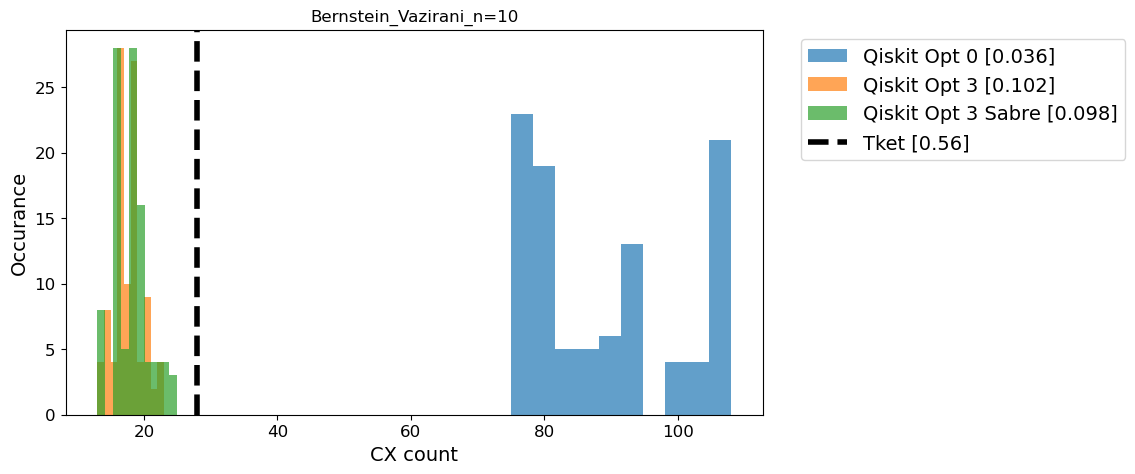

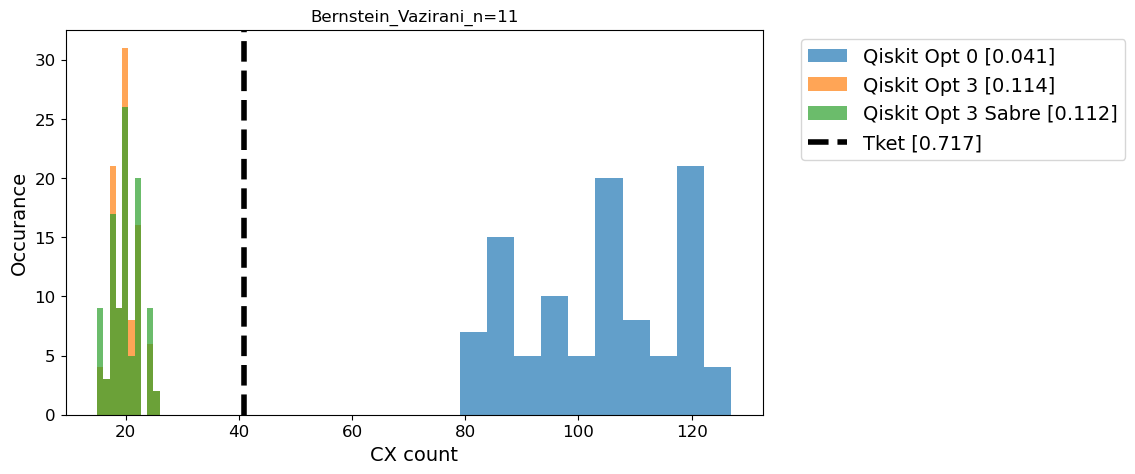

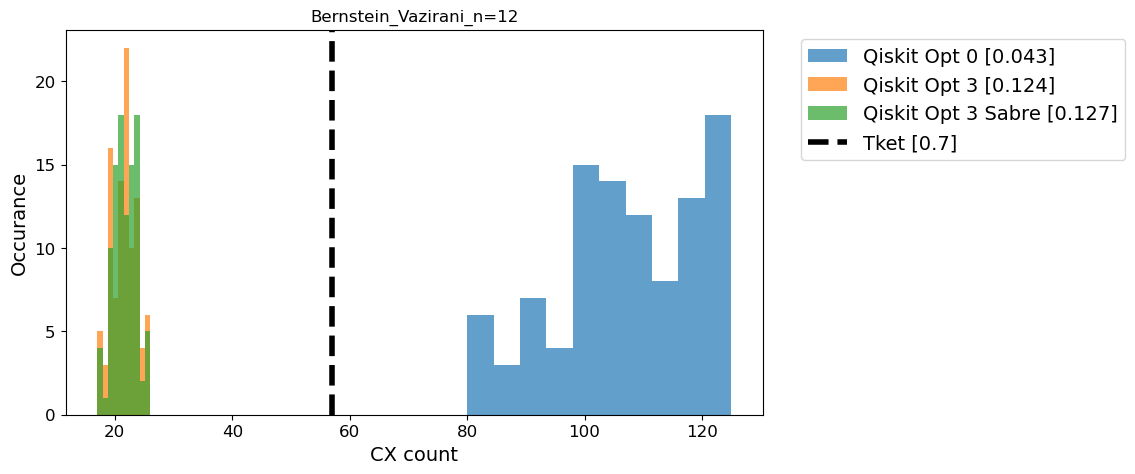

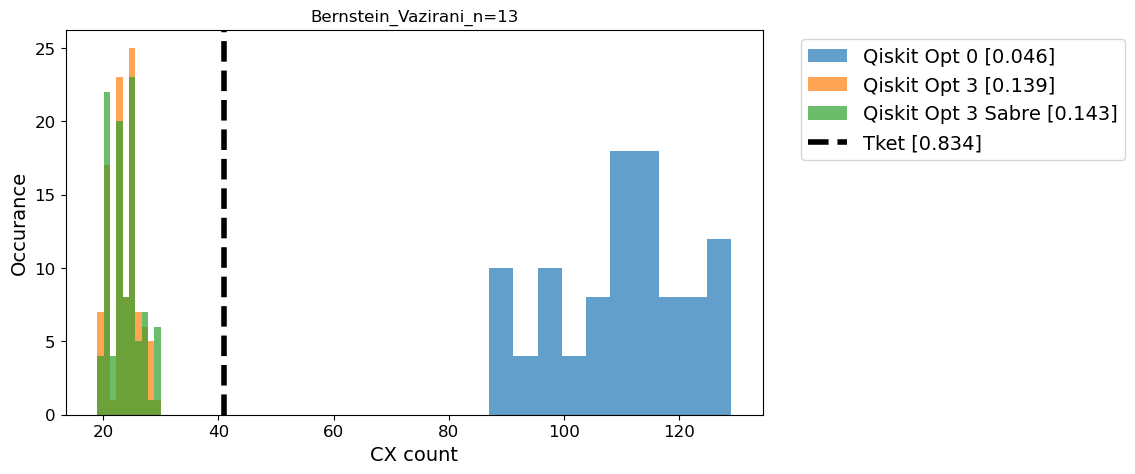

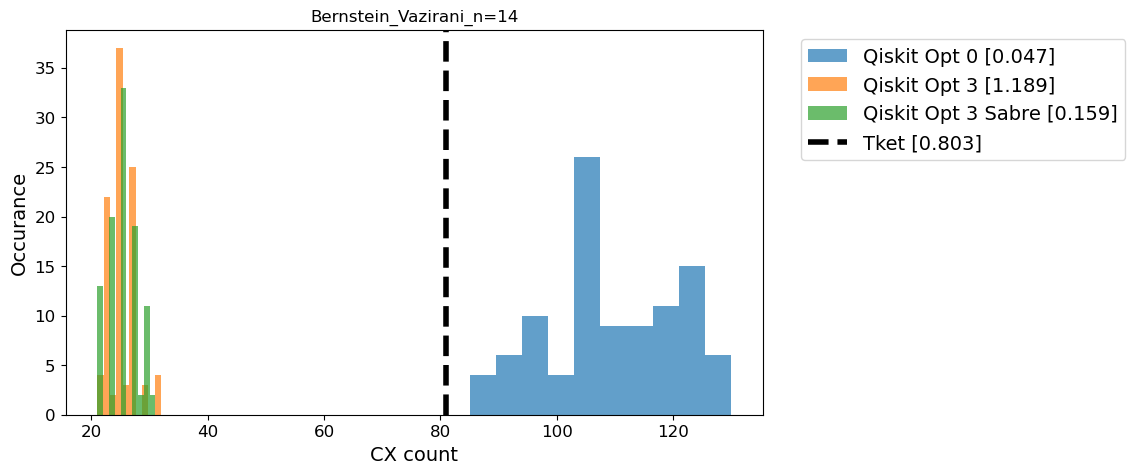

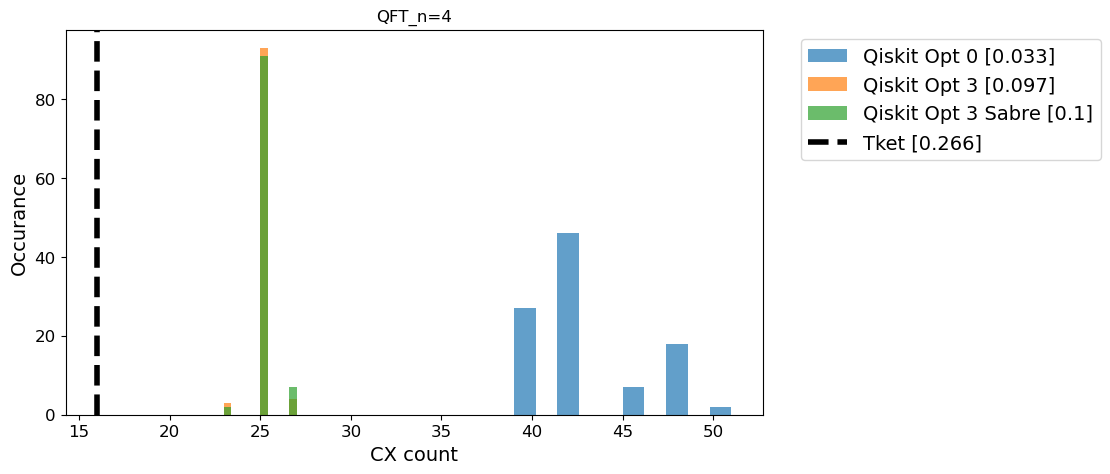

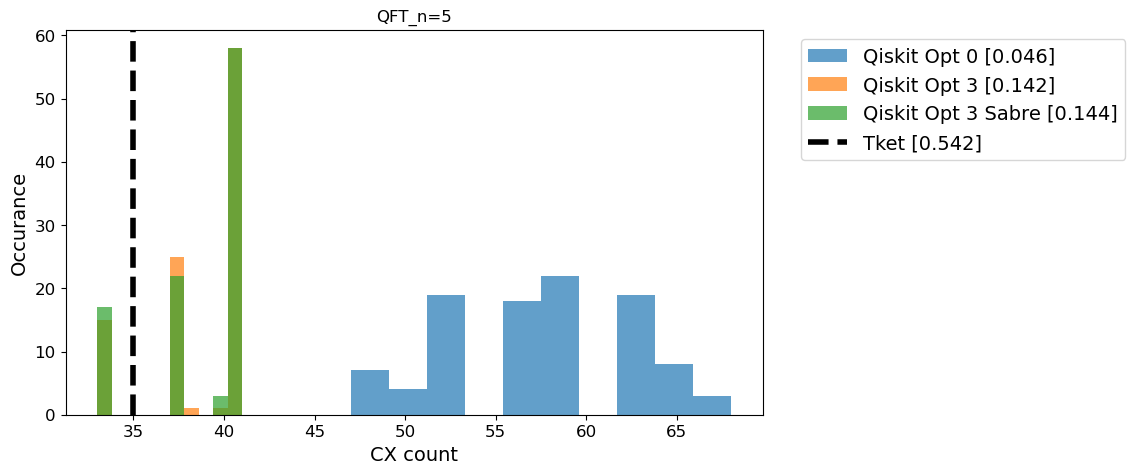

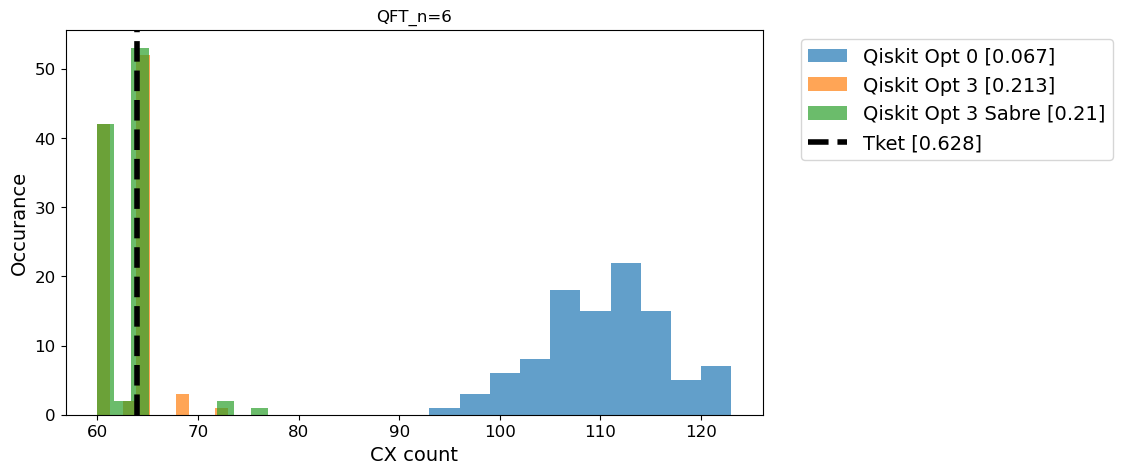

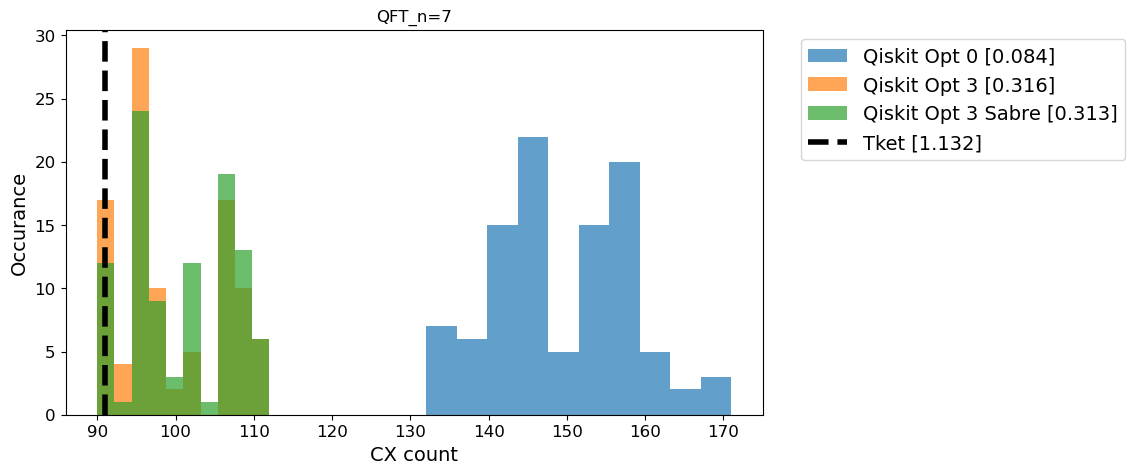

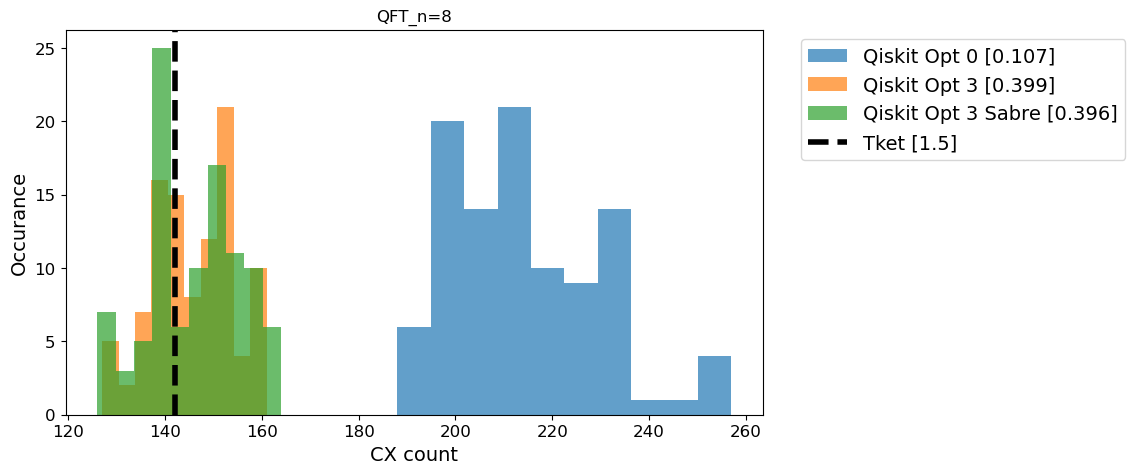

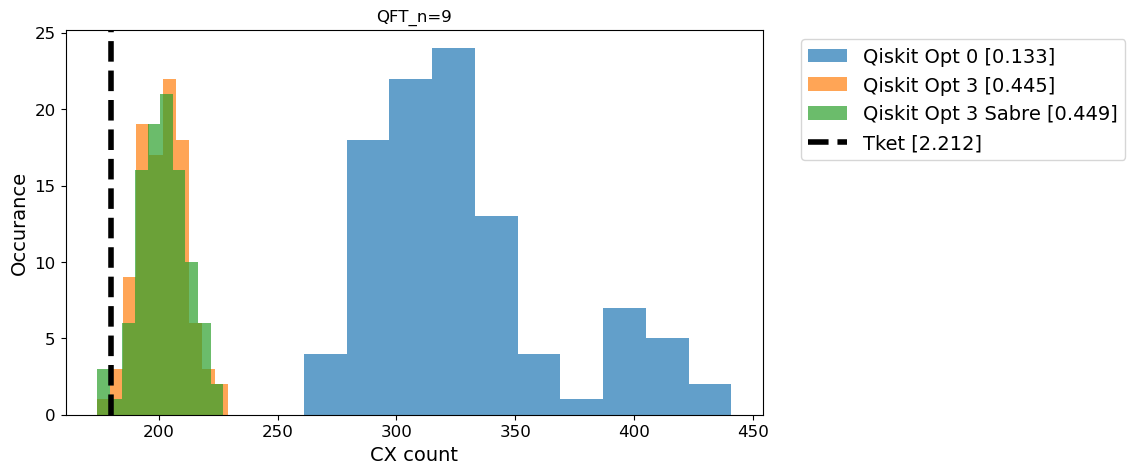

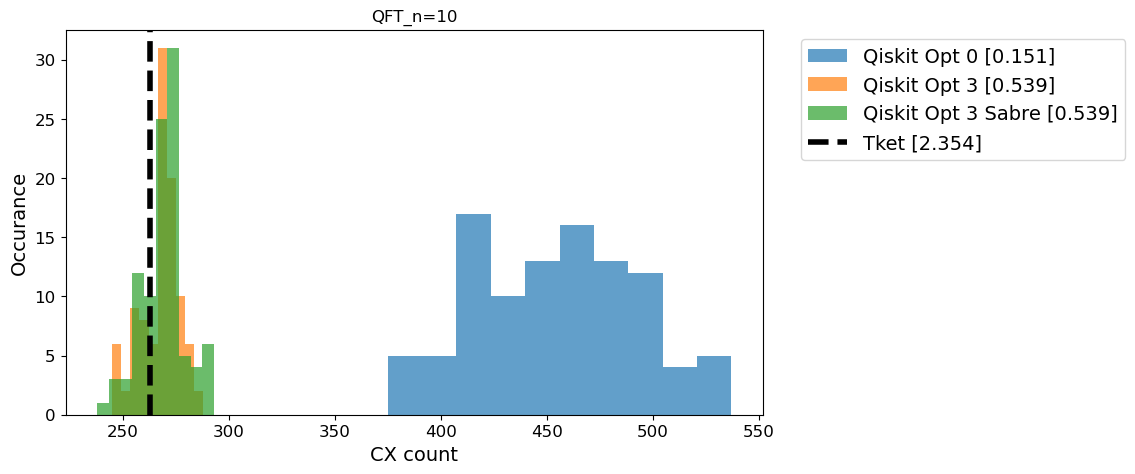

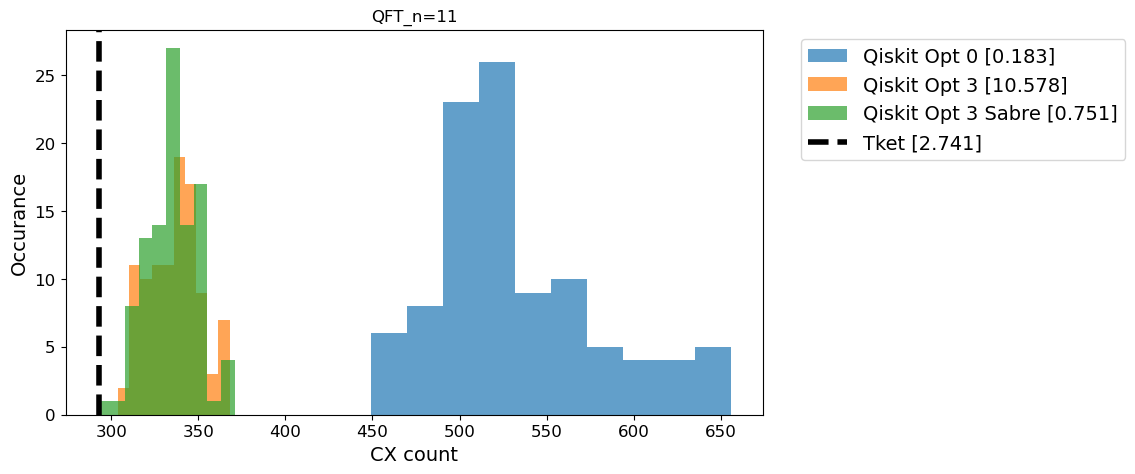

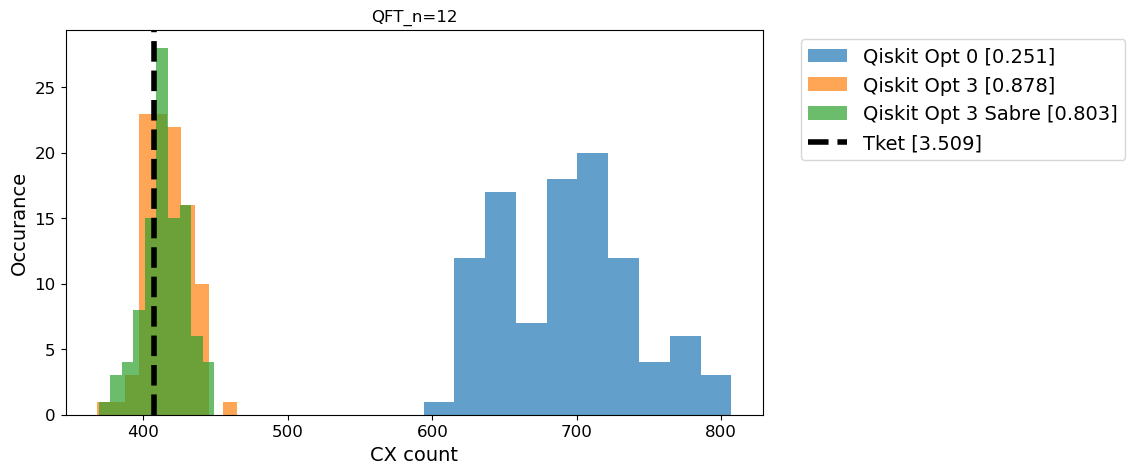

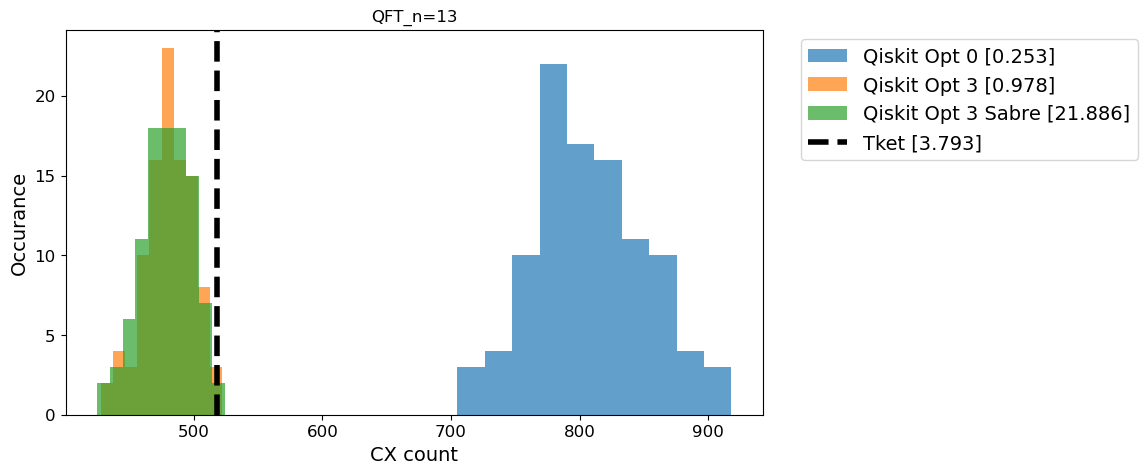

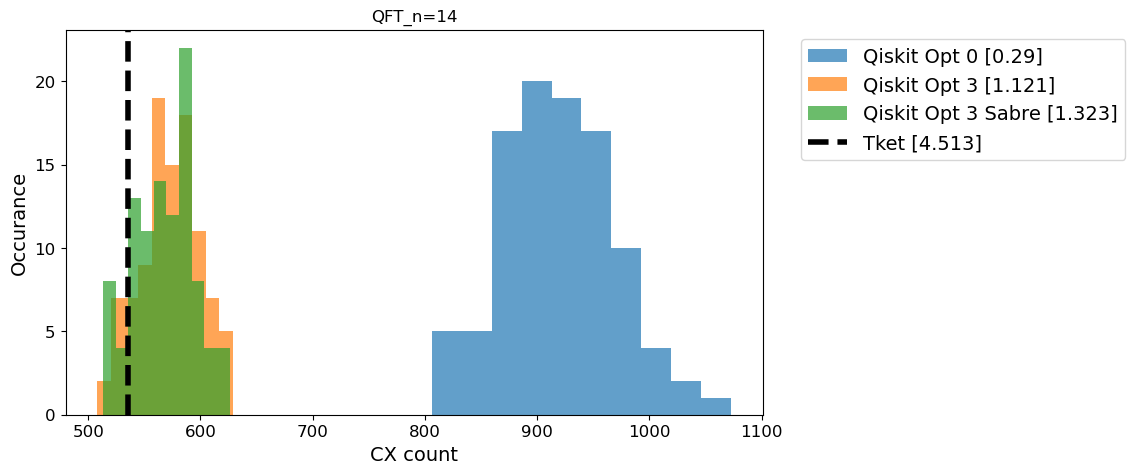

In [11]:
qcs = []
transpiled_qcs = []

for algo_name, algo in algorithms.items():
    for n in range(min_qubits, max_qubits+1):
        qc = algo.test(n)
        qcs.append(qc)
        title = '{}_n={}'.format(algo_name, n)
        fig, tqcs = compiler_benchmark(qc, backend, title)
        transpiled_qcs.extend(tqcs)
        plt.show(fig)


# Save qcs and transpiled_qcs

In [15]:
import pickle

with open('save_transpile_{}.pickle'.format(backend.name), 'wb') as file:
    pickle.dump((qcs, transpiled_qcs, min_qubits, max_qubits, tuple(algorithms.keys()), tuple(techniques.keys())), file)